# k-nearest-Neighbour


## Aufgaben

1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich geeignete Merkmale, die Sie aus den Bildern extrahieren können und extrahieren Sie die Merkmale._
3. _Wählen Sie zur Merkmalsreduktion je eine Methoden aus dem Bereich Merkmalstransformation und Merkmalsselektion aus. Geben Sie in Ihrem Kurzreport an, aus welchem Grund Sie die jeweilige Methode gewählt haben. Vergleichen Sie am Ende die Performance Ihres ML-Systems ohne Reduktion, mit der gewählten Transformation und der gewählten Selektion._
4. _Implementieren Sie mithilfe von Scikit Learn einen k-Nearest Neighbor Klassifikators zur Lösung der Klassifikationsaufgabe. Führen Sie eine Hyperparameter-Optimierung in Bezug auf k durch und stellen Sie die Erkenntnisse in Ihrem Kurzreport dar_
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie zur Evaluation eine Kreuzvalidierung (3-fold)._

##### Imports

In [9]:
import tensorflow as tf
from pathlib import Path
import sys
import numpy as np
from tqdm import tqdm
import random
from skimage.feature import local_binary_pattern, canny
import scipy.stats as ss
from skimage.measure import regionprops_table
from skimage.morphology import label as skimage_label
import pandas as pd
import datetime
import itertools
import bisect
from functools import reduce
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
    RobustScaler,
)
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, FastICA
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    SelectKBest,
    SelectPercentile,
    RFE,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from utils.utils import setup_dataset, getDognames

## Laden der Daten

Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_, _Deep Learning_ und _Transfer Learning_ und wurde somit in `setup.py` ausgelagert.

Es werden alle Hunde aus dem Datensatz entfernt, die nicht eine der Label IDs in `Config.DOG_LABEL_IDS` haben. Danach wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.    

Bei der Hundeauswahl wurde darauf geachtet, dass die Merkmale, wie Farbe, Größe, Haare usw. sich stark unterscheiden um somit die Varianz zu erhöhen.

#### Hund 1: Afghan hound
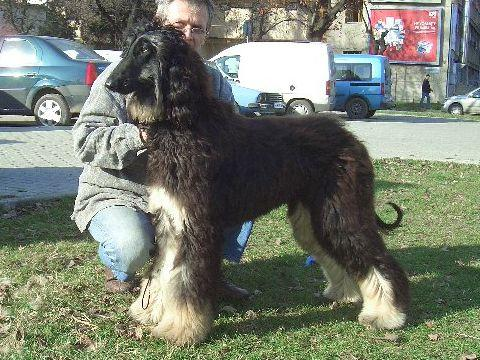
#### Hund 2: African hunting dog
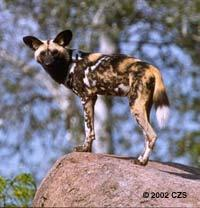
#### Hund 3: Dhole
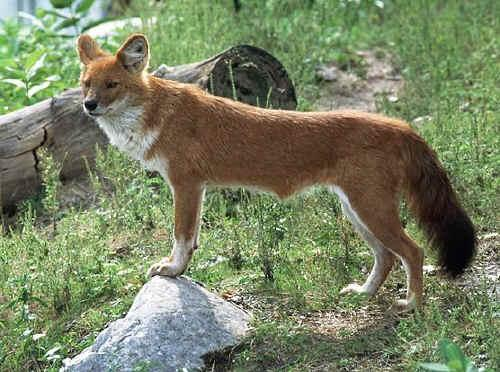
#### Hund 4: Doberman
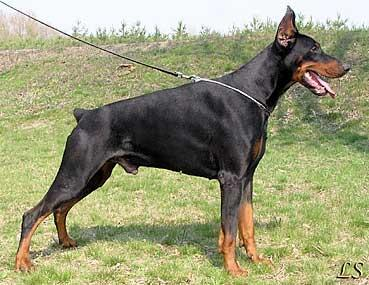
#### Hund 5: Komondor
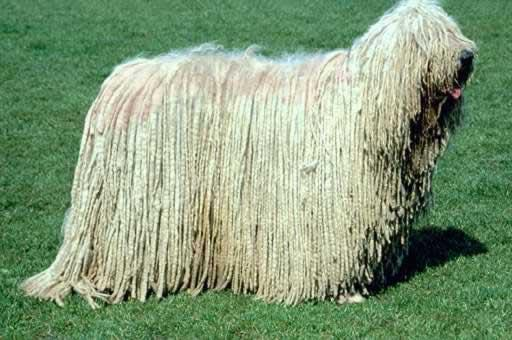

In [6]:
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

labels = [9, 77, 85, 118, 119]
train_dataset, test_dataset, table, info = setup_dataset(
    "../dataset", show_examples=False, labels=labels
)

Total Image count:  500
Train Dataset Size: 375
Test Dataset Size: 125


2024-12-18 22:13:46.316448: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Erstellen des Feature Vektors


Die extrahierten Merkmale lassen sich in zwei Kategorien aufteilen:

### 1. Farbbasierte Merkmale

Bei diesem Schritt wird ein Histogramm für jede der drei R-G-B Ebenen erstellt. Dies geschieht mit `np.histogram()` und einer Anzahl von 255 _bins_.

Anschließend werden jeweils die folgenden statistischen Metriken erhoben:
- Minimum/Maximum
- Mittelwert
- Varianz
- Schiefe -> Art und Stärke der Asymmetrie
- Kurtosis -> Abweichung im Vergleich zur Normalverteilung

Die Hoffnung bei der Erhebung dieser Metriken ist, dass sie die großen farblichen Unterschiede eines schwarzen Dobermanns, weißen Komondors und eines rötlichen Dholes abbilden.

Aus den obig genannten 6 Metriken und 3 Ebenen ergeben sich **18 Features**.

### 2. Texturbasierte Merkmale

Die Hunde unterscheiden sich stark in ihren Körperformen und Felltexturen.
Wähhrend der African Hunting Dog eher gefleckt ist, weißen Komondor und Afghan Dog langes, stark vertikal fallendes Fell auf. Dholes haben weniger markante Texturen und Dhole hat sehr glattes Fell.

Diese Texturen sollten anhand zweier Funktionen abgebildet werden:

##### `computeRegionFeatures()`
Hier wird das Bild auf Grautöne reduziert und danach mit einem Canny-Filter Kanten gefunden.
Anhand dieser werden unterschiedliche Regionen im Bild ermittelt.


Ziel dieser Funktion war, dass sich im Speziellen die markanten langen Haare des Komondors in der Metrik `"bbox_height_width_ratio"` widerspiegeln. Die Anzahl der Regionen sollte Aufschluss geben, wie grobkörnig die Texturen im Bild sind und so bspw. Dobermann und African Hunting Dog unterscheiden.

Zwei Dinge sollen die berechneten Features robuster machen:
1. Für die Metriken `"area_bbox"`, `"axis_major_length"` und `"axis_minor_length"` werden im Vorhinein Extremfall-Regionen gefiltert,
2. Oft wurden aus einer statistischen Analyse aller Regionen das erste Quartil, der Mittelwert, das dritte Quartil und die Standardabweichung entnommen.

Insgesamt wurden hiermit **23 Features** berechnet.

##### `computeLBPfeatures()`

Diese Funktion wurde implementiert, um mithilfe von local binary patterns feingranularere und subtilere Texturen wie in `computeRegionFeatures()` abzubilden.

Auch hier wird das Bild zu allererst in ein graues Bild überführt. Dann wird die Analyse über die Funktion `local_binary_pattern()` durchgeführt.

Danach wird ein Histogramm hieraus erstellt. Jedoch werden hiervon keine statistischen Metriken enthoben. Diese Entscheidung wurde getroffen, da Texturarten teilweise an unterschiedlichen Rändern des Histogramms liegen. Hier bspw. einen Mittelwert zu berechnen wäre wenig aussagekräftig.

Stattdessen werden hier die Indizes der vier größten Werte zurückgegeben. Somit ergeben sich **4 Features**.

---

Zusammenfassend ergeben sich somit **45 Features**.


In [11]:
def colorTensor2grayNparray(image):
    return tf.image.rgb_to_grayscale(image).cpu().numpy()[:, :, 0]

def computeHistogrammFeatures(img):
    output = []

    for layer in [0, 1, 2]:
        values, _ = np.histogram(img[:, :, layer], bins=np.arange(256))
        nobs, (minimum, maximum), mean, variance, skewness, kurtosis = ss.describe(
            values
        )
        output += (mean, skewness, kurtosis, minimum, maximum, variance)
    return output

def computeRegionFeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)

    edges = canny(img_grayscale_np, 1.5)
    label_image = skimage_label(edges)

    properties = (
        "bbox",
        "area_bbox",
        "axis_major_length",
        "axis_minor_length",
        "orientation",
        "solidity",
    )
    regions = regionprops_table(label_image, properties=properties)
    df = pd.DataFrame(regions)

    # Filter outliers
    df = df[(df["area_bbox"] > 10) & (df["area_bbox"] < df["area_bbox"].quantile(0.9))]
    df = df[
        (df["axis_major_length"] > 1)
        & (df["axis_major_length"] < df["axis_major_length"].quantile(0.95))
    ]
    df = df[
        (df["axis_minor_length"] > 1)
        & (df["axis_minor_length"] < df["axis_minor_length"].quantile(0.95))
    ]

    num_regions = df.shape[0]
    df["bbox_height_width_ratio"] = (df["bbox-3"] - df["bbox-1"]) / (
        df["bbox-2"] - df["bbox-0"]
    )
    df["axis_ratio"] = (df["axis_major_length"]) / (df["axis_minor_length"])
    df = df.drop(columns=["bbox-0", "bbox-1", "bbox-2", "bbox-3"])
    df = df.describe()

    return (
        num_regions,
        df.at["mean", "bbox_height_width_ratio"],
        df.at["std", "bbox_height_width_ratio"],
        df.at["25%", "bbox_height_width_ratio"],
        df.at["75%", "bbox_height_width_ratio"],

        df.at["mean", "axis_ratio"],
        df.at["std", "axis_ratio"],
        df.at["25%", "axis_ratio"],
        df.at["75%", "axis_ratio"],

        df.at["mean", "area_bbox"],
        df.at["std", "area_bbox"],
        df.at["25%", "area_bbox"],
        df.at["75%", "area_bbox"],

        df.at["mean", "axis_major_length"],
        df.at["std", "axis_major_length"],
        df.at["25%", "axis_major_length"],
        df.at["75%", "axis_major_length"],

        df.at["mean", "axis_minor_length"],
        df.at["std", "axis_minor_length"],
        df.at["25%", "axis_minor_length"],
        df.at["75%", "axis_minor_length"],

        df.at["mean", "orientation"],
        df.at["std", "orientation"],
    )

def computeLBPfeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)
    radius = 3
    n_points = radius * 8
    lbp = local_binary_pattern(img_grayscale_np, n_points, radius)
    hist, _ = np.histogram(
        lbp.ravel(), bins=np.arange(3, n_points + 3), range=(5, n_points + 2)
    )
    hist = hist.astype("float")
    hist /= hist.sum()
    sorted_with_index = sorted(enumerate(hist), key=lambda x: -x[1])
    max_values_indices = [index for index, value in sorted_with_index]
    return max_values_indices[:4]

In [12]:
def imageToVector(img) -> np.ndarray:
    extractionMethods = (
        computeHistogrammFeatures,
        computeRegionFeatures,
        computeLBPfeatures,
    )
    vector = []
    for method in extractionMethods:
        features = method(img)
        vector += features
    return np.array(vector)

def datasetToVectorLabels(dataset):
    vectors, labels = [], []
    tqdm_config = {
        "total": len(list(dataset.as_numpy_iterator())),
        "desc": "Iterating images:",
        "bar_format": "{l_bar}{bar:20}{r_bar}{bar:-10b}",
    }
    for sample in tqdm(dataset, **tqdm_config):
        vectors.append(imageToVector(sample["image"].numpy()))
        labels.append(sample["label"].numpy())
    vectors = np.array(vectors)
    return vectors, labels

x_train_initial, y_train = datasetToVectorLabels(train_dataset)
x_test_initial, y_test = datasetToVectorLabels(test_dataset)

Iterating images:: 100%|████████████████████| 375/375 [01:17<00:00,  4.81it/s]
2024-12-18 23:04:32.207366: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Iterating images:: 100%|████████████████████| 125/125 [00:28<00:00,  4.43it/s]


## Model an die Daten fitten


Die folgende Funktion nimmt die in `configuration` spezifizierten Parameter und erstellt ein Model mit diesen. Dass diese Funktion so variabel ist und sich Funktionen zur Normalisierung, Merkmalsextraktion und Merkmalsreduktion ändern lassen erlaubt später eine vielfältigere Hyperparameteroptimierung.

Die Funktion durchgeht die folgenden Schritte:
1. Merkmale normalisieren
2. Merkmale selektieren
3. Merkmale reduzieren
4. Model fitten

Bei Ausführung der Zelle werden die Ergebnisse einer bereits durchgeführten Hyperparameter-Grid-Search geladen und die beste Konfiguration geladen.


In [13]:
def fit_with_config(configuration, x_train_initial, y_train, x_test_initial):
    (
        n_neighbors,
        scaler_name,
        selector_name,
        percentile_value,
        # n_features_to_select,
        reductor_name,
        n_features_reduction,
    ) = configuration

    n_features_reduction = int(n_features_reduction)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Normalization
    get_scaler = {
        "standard_scaler": StandardScaler,
        "minmax_scaler": MinMaxScaler,
        "maxabs_scaler": MaxAbsScaler,
        "robust_scaler": RobustScaler,
    }
    scaler = get_scaler[scaler_name]()
    x_train = scaler.fit_transform(x_train_initial)
    x_test = scaler.transform(x_test_initial)

    # Feature Selection
    get_selector = {
        # "kbest": SelectKBest(k=n_features_to_select),
        "percentile": SelectPercentile(percentile=percentile_value),
        # "sequential": SequentialFeatureSelector(
        #    knn,
        #    n_features_to_select=n_features_to_select
        #   ),
        # "rfe": RFE(
        #   knn,
        #   n_features_to_select=n_features_to_select
        #   ),
    }
    selector = get_selector[selector_name]
    x_train = selector.fit_transform(x_train, y_train)
    x_test = selector.transform(x_test)

    # Feature Reduction
    if n_features_reduction is not None:
        get_reductor = {
            "pca": PCA,
            "incremental_pca": IncrementalPCA,
            "kernel_pca": KernelPCA,
            "fast_ica": FastICA,
        }
        reductor = get_reductor[reductor_name](n_components=n_features_reduction)
        x_train = reductor.fit_transform(x_train)
        x_test = reductor.transform(x_test)

    knn.fit(x_train, y_train)
    return knn, x_train, x_test


df = pd.read_csv("20k.csv", index_col=0)
best_config = df.loc[df["score"].idxmax()].drop("score")
knn, x_train, x_test = fit_with_config(
    list(best_config), x_train_initial, y_train, x_test_initial
)

print("CONFIG:")
print()
print(best_config)
print()
print(f"Train Accuracy: {knn.score(x_train, y_train)}")
print(f"Test Accuracy: {knn.score(x_test, y_test)}")

CONFIG:

n_neigbors                           11
scaler_name             standard_scaler
selector_name                percentile
percentile_value                     26
reductor_name           incremental_pca
n_features_reduction                5.0
Name: 0, dtype: object

Train Accuracy: 0.504
Test Accuracy: 0.384


## Hyperparameter Optimieren (k-Fold)


In dieser Zelle kann eine eigens implementierte k-Fold Hyperparameteroptimierung mit Grid Search durchgeführt werden.

Folgende Parameter können variiert werden:
- Anzahl der Nachbarn (k von k-nearest-Neighbours)
- Normalisierungsfunktion
    - `StandardScaler`
    - `MinMaxScaler`
    - `MaxAbsScaler`
    - `RobustScaler`
- Selektionsfunktion
    - `SelectPercentile`
    - `SelectKBest`
    - `SequentialFeatureSelector`
    - `RFE`
- Anzahl selektierten Features
- Reduktionsfunktion
    - `PCA`
    - `KernelPCA`
    - `IncrementalPCA`
    - `FastICA`
- Anzahl der Features nach Reduktion

Hieraus werden alle möglichen Parameterkombinationen erstellt und mit 5-fold cross validation geprüft. Anschließend werden die Läufe nach ihrem score sortiert und optional gespeichert.

In [109]:
perform_hyperparameter_optimisation = False
store = True
n_validations = 5

if perform_hyperparameter_optimisation:
    parameters = {
        "n_neigbors": list(range(3, 20)),
        "scaler_name": [
            "standard_scaler",
            "minmax_scaler",
            "maxabs_scaler",
            "robust_scaler",
        ],
        "selector_name": ["percentile"],
        "percentile_value": list(range(10, 40)),
        # "n_features_to_select": [7,10,12,14,16, None],
        "reductor_name": ["pca", "incremental_pca", "kernel_pca", "fast_ica"],
        "n_features_reduction": [2, 3, 4, 5, None],
    }
    all_combs = itertools.product(*parameters.values())
    n_configs = reduce(
        lambda x, y: x * y, [len(values) for values in parameters.values()], 1
    )
    combs_with_scores = []
    tqdm_config = {
        "total": n_configs,
        "desc": "Testing configs:",
        "bar_format": "{l_bar}{bar:20}{r_bar}{bar:-10b}",
    }
    for configuration in tqdm(all_combs, **tqdm_config):

        # Perform pipeline
        knn, x_train, x_test = fit_with_config(
            configuration, x_train_initial, y_train, x_test_initial
        )
        score = cross_val_score(knn, x_train, y_train, cv=n_validations)
        bisect.insort(
            combs_with_scores, (np.mean(score), *configuration), key=lambda x: -x[0]
        )

    df = pd.DataFrame(combs_with_scores, columns=["score"] + list(parameters.keys()))
    if store:
        df.to_csv(f"{datetime.datetime.now().isoformat()}.csv", index=False)

    print("CONFIG:")
    print()
    print(best_config)
    print()
    print(f"Train Accuracy: {knn.score(x_test, y_test)}")
    print(f"Test Accuracy: {knn.score(x_test, y_test)}")

## Ergebnisse Visualisieren


#### Boxplots

In der Folgenden Zelle kann die Performance des Models in Abhängigkeit zu unterschiedlichen Parametern bestimmt werden, welche in `attributes` spezifiziert werden können.

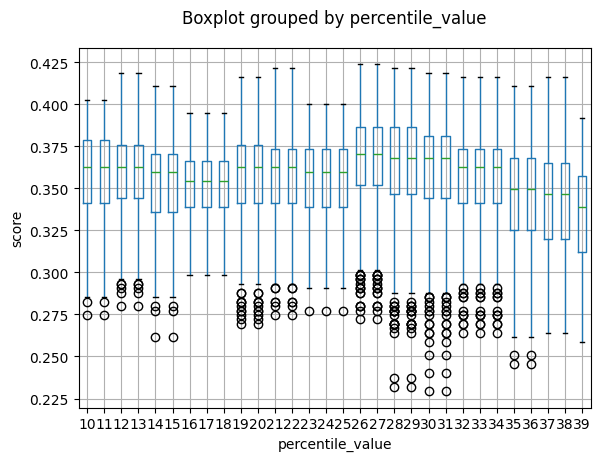

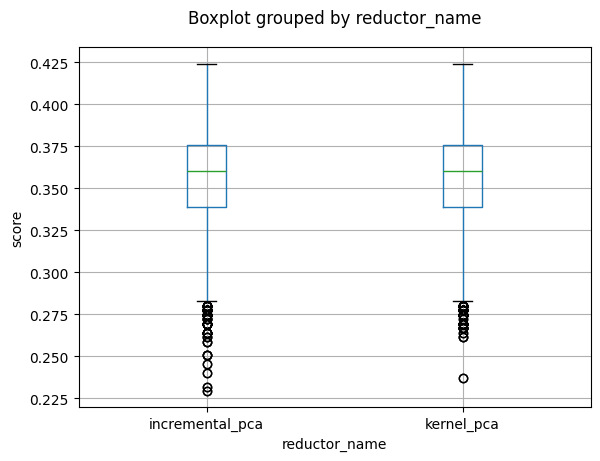

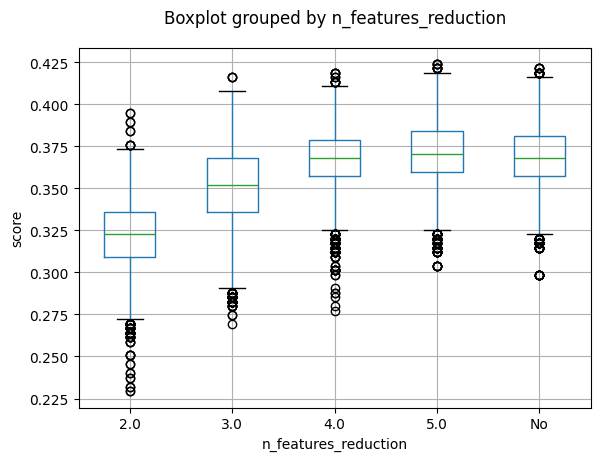

In [ ]:
attributes = ["percentile_value", "reductor_name", "n_features_reduction"]
combs_with_scores = pd.read_csv("20k.csv")

for attribute in attributes:
    boxplot = combs_with_scores.fillna("No").boxplot(column="score", by=attribute)
    plt.ylabel("score")
    plt.title("")

#### Konfusionsmatrizen

Die folgenden 

TRAIN DATEN
                     precision    recall  f1-score   support

              dhole       0.48      0.68      0.56        73
       Afghan_hound       0.53      0.47      0.50        78
           Doberman       0.58      0.47      0.52        77
African_hunting_dog       0.45      0.44      0.44        73
           komondor       0.50      0.46      0.48        74

           accuracy                           0.50       375
          macro avg       0.51      0.50      0.50       375
       weighted avg       0.51      0.50      0.50       375



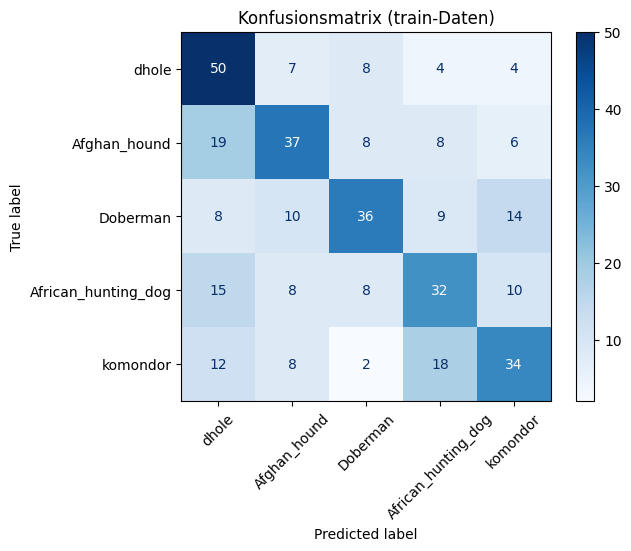

--------------------------------------------------------------------------------
TEST DATEN
                     precision    recall  f1-score   support

       Afghan_hound       0.35      0.52      0.42        27
African_hunting_dog       0.28      0.23      0.25        22
              dhole       0.53      0.35      0.42        23
           Doberman       0.50      0.44      0.47        27
           komondor       0.32      0.35      0.33        26

           accuracy                           0.38       125
          macro avg       0.40      0.38      0.38       125
       weighted avg       0.40      0.38      0.38       125



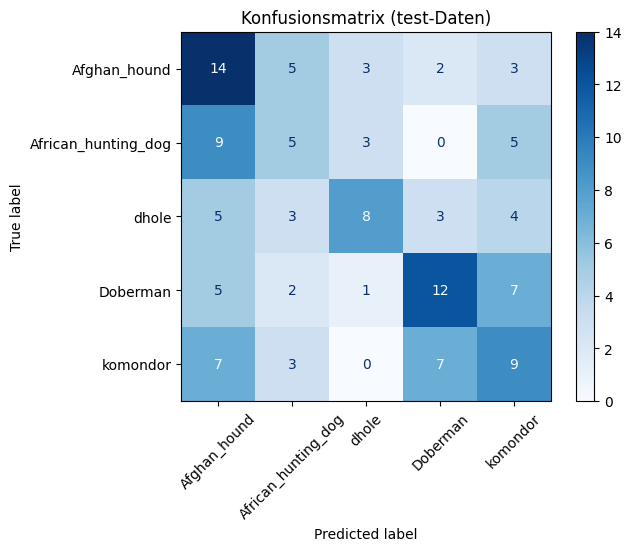

--------------------------------------------------------------------------------


In [ ]:
dataset_collections = {
    "train": [train_dataset, x_train, y_train],
    "test": [test_dataset, x_test, y_test],
}

for name, (initial_dataset, x, y) in dataset_collections.items():
    predicted = knn.predict(x)
    class_labels = list(getDognames(initial_dataset).values())

    print(name.upper() + " DATEN")
    print(classification_report(y_true=y, y_pred=predicted, target_names=class_labels))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y, predicted), display_labels=class_labels
    )
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Konfusionsmatrix ({name}-Daten)")
    plt.show()
    print("-" * 80)

#### Colored Class Map

Zu guter letzt werden die Klassengrenzen noch in einem zwei-dimensionalen Space geplottet.

Hierzu wird zuallererst die beste Konfiguration geladen, bei der die Daten auf zwei Dimensionen reduziert werden. Dann wird ein Model hierzu gefittet. Anschließend werden die Farbflächen berechnet. Zuletzt werden die Plots erstellt. Die Kreise im Plot stehen hierbei für die Trainingsdaten, die Kreuze für die Testdaten.

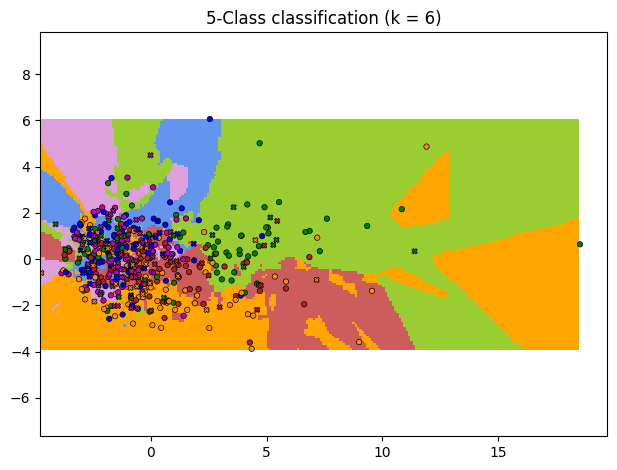

In [ ]:
h = 0.1

# Get well-performing configuration with mapping to two dimensions
configurations_df = pd.read_csv("20k.csv", index_col=0)
filtered_df = configurations_df[configurations_df["n_features_reduction"] == 2]
config = list(filtered_df.loc[filtered_df["score"].idxmax()].drop(labels=["score"]))

# Model trainieren
knn_2, x_train_2, x_test_2 = fit_with_config(
    config, x_train_initial, y_train, x_test_initial
)
knn_2.score(x_test_2, y_test)


# Farbflächen erstellen
x_coords_train, y_coords_train = zip(*x_train_2)
x_coords_test, y_coords_test = zip(*x_test_2)
x_max, x_min = max(x_coords_train + x_coords_test), min(x_coords_train + x_coords_test)
y_max, y_min = max(y_coords_train + y_coords_test), min(y_coords_train + y_coords_test)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = knn_2.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

# Labelabstände homogenisieren
y_train_equally_distributed = np.array(y_train.copy())
y_test_equally_distributed = np.array(y_test.copy())
for index, label_value in enumerate(labels):
    Z[Z == label_value] = index
    y_train_equally_distributed[y_train_equally_distributed == label_value] = index
    y_test_equally_distributed[y_test_equally_distributed == label_value] = index

cmap_light = ListedColormap(
    ["indianred", "orange", "yellowgreen", "cornflowerblue", "plum"]
)
cmap_bold = ListedColormap(["firebrick", "darkorange", "green", "blue", "m"])

# Plots erstellen
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="nearest")

plt.scatter(
    x=x_coords_train,
    y=y_coords_train,
    c=y_train_equally_distributed,
    cmap=cmap_bold,
    edgecolors="k",
    linewidths=0.5,
    s=15,
)

plt.scatter(
    x=x_coords_test,
    y=y_coords_test,
    c=y_test_equally_distributed,
    cmap=cmap_bold,
    edgecolors="k",
    linewidths=0.5,
    marker="X",
    s=15,
)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.axis("equal")
plt.title(f"5-Class classification (k = {config[0]})")
plt.tight_layout()
plt.autoscale(True)
plt.show()

## Zusammenfassung & Ausblick

Im Entwicklungsprozess erreichte das Model k-Fold accuracies von bis zu **46%** und Test-accuracies von bis zu **39%**. Damit performt es doppelt so gut wie reines Raten.

Die Hyperparameteroptimierung auf eine Vielzahl an Parametern auszuweiten erwies sich als eine gute Möglichkeit, um die optimalen Kombinationen zu ermitteln.

In einem weiteren Schritt könnten die aktuellen Features kritisch auf Relevanz und Redundanz überprüft werden und außerdem weitere Features erhoben werden.